In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# 1. Parametri e caricamento dati
FILE_PATH = r'..\Fuorigaranzia\STAMPA GIORNALE DI MAGAZZINO 2022 2023 2024 solo vendita articoli.xlsx'
SHEET_NAME = 0   # oppure il nome esplicito del foglio
FORECAST_HORIZON = 12  # trimestri = 3 anni

# 2. Lettura e pulizia
df = pd.read_excel(FILE_PATH, sheet_name=SHEET_NAME)
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
df = df[['Data', 'Articolo', 'Quantità']].dropna()

# 3. Aggregazione trimestrale per articolo
quarterly = (
    df
    .groupby([pd.Grouper(key='Data', freq='QE'), 'Articolo'])['Quantità']
    .sum()
    .unstack(fill_value=0)
)

# 4. Individuazione dell’articolo top
totali = quarterly.sum()
top_articolo = totali.idxmax()
print(f"Articolo più venduto: {top_articolo} ({totali[top_articolo]} pezzi)")

# 5. Serie storica trimestrale
ts = quarterly[top_articolo]
ts.index.freq = 'QE'  # imposta la frequenza trimestrale


Articolo più venduto: 016.04.03.00045 (263 pezzi)


                               SARIMAX Results                                
Dep. Variable:        016.04.03.00045   No. Observations:                   12
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -50.231
Date:                Tue, 08 Jul 2025   AIC                            106.463
Time:                        18:50:00   BIC                            107.657
Sample:                    03-31-2022   HQIC                           105.710
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0178      1.592      0.011      0.991      -3.102       3.137
ma.L1         -0.9953     56.254     -0.018      0.986    -111.252     109.261
sigma2       435.6458   2.43e+04      0.018      0.9

C:\Users\kevin.vargu\AppData\Local\Temp\ipykernel_10996\1008278259.py:8: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  fc_index = pd.date_range(ts.index[-1] + pd.offsets.QuarterEnd(),


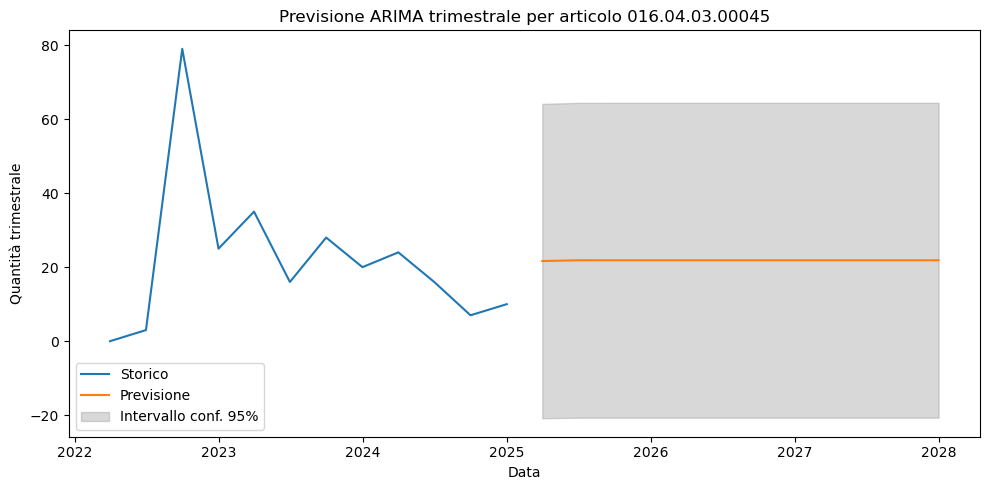

In [17]:
# 6. Modellazione ARIMA (es: (1,1,1), puoi cambiare dopo verifica AIC/BIC)
model = ARIMA(ts, order=(1, 1, 1))
res = model.fit()
print(res.summary())

# 7. Previsione
forecast = res.get_forecast(steps=FORECAST_HORIZON)
fc_index = pd.date_range(ts.index[-1] + pd.offsets.QuarterEnd(),
                         periods=FORECAST_HORIZON, freq='Q')
fc_mean = forecast.predicted_mean
fc_conf = forecast.conf_int()

# 8. Plot
plt.figure(figsize=(10, 5))
plt.plot(ts, label='Storico')
plt.plot(fc_index, fc_mean, label='Previsione')
plt.fill_between(fc_index,
                 fc_conf.iloc[:, 0],
                 fc_conf.iloc[:, 1],
                 color='gray', alpha=0.3, label='Intervallo conf. 95%')
plt.title(f'Previsione ARIMA trimestrale per articolo {top_articolo}')
plt.xlabel('Data')
plt.ylabel('Quantità trimestrale')
plt.legend()
plt.tight_layout()
plt.show()

# 9. Esportazione
df_fc = pd.DataFrame({
    'Previsione': fc_mean.values,
    'Lower CI': fc_conf.iloc[:, 0].values,
    'Upper CI': fc_conf.iloc[:, 1].values
}, index=fc_index)